# Cal-CRAI Index: Built Environment Domain

**Order of operations**: 
1) Metric handling \
   1a - Retrieve data \
   1b - Min-max standardization \
   1c - Set vulnerability orientation (pos for vulnerable, neg for resilience)

2) Calculate indicators \
   2a - Min-max standardization \
   2b - Finalize domain score
   
3) Visualize, save, and export domain score dataframe

In [1]:
import pandas as pd
import os
import sys
import warnings

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.write_metadata import append_metadata
from scripts.utils.cal_crai_plotting import plot_domain_score, plot_region_domain
from scripts.utils.cal_crai_calculations import (handle_outliers, min_max_standardize, process_domain_csv_files, 
                                        compute_averaged_indicators, compute_summed_indicators, indicator_dicts, 
                                        add_census_tracts, domain_summary_stats)

## Step 1: Metric level
### 1a) Retrieve metric files and process

In [2]:
# set-up
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/'

pull_csv_from_directory(bucket_name, aws_dir, output_folder='aws_csvs', search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data/.


### Process and merge Built Environment metric files together

In [ ]:
# domain-specific
domain_prefix = 'built_'
input_folder = r'aws_csvs'
output_folder = domain_prefix + "folder"
meta_csv = r'../utils/calcrai_metrics.csv'

merged_output_file = f'concatenate_{domain_prefix}metrics.csv'
metric_vulnerable_resilient_dict = process_domain_csv_files(domain_prefix, input_folder, output_folder, meta_csv, merged_output_file)

Processed and saved 20 CSV files within built_domain.

Metric resilience/vulnerable dictionary created and called: metric_vulnerable_resilient_dict

All entries within the island tract (6075980401) are NaN.

Number of infinite entries in the DataFrame: 0
Replacing infinite entries (if any) with NaN
Number of infinite entries in the DataFrame after replacement: 0

File processing complete, dataframe will now be saved as a .csv
Processed CSV saved as concatenate_built_metrics.csv


### Take a look at the resulting dictionary
We will use this later to refactor certain metrics

In [5]:
metric_vulnerable_resilient_dict

{'vulnerable': ['low_internet_download_flag',
  'percent_housing_before_1980',
  'percent_mobile_homes',
  'percent_without_kitchen_facilities_or_plumbing',
  'estimated_total_vacant_housing_units',
  'avg_num_psps_event',
  'number_of_bottlenecks'],
 'resilient': ['cellular_towers_data_count',
  'percent_underground_transmission_lines',
  'microwave_towers_data_count',
  'mobile_towers_data_count',
  'paging_towers_data_count',
  'power_plant_count',
  'radio_towers_data_count',
  'number_of_airports',
  'numbers_of_bridges',
  'highway_length_in_miles',
  'railway_length_in_miles',
  'tv_contour_data_count',
  'num_exclusive_wastewater_facilities']}

### Now, take a look at the merged singluar csv file

In [6]:
# read-in and view processed data
processed_built_df = pd.read_csv(merged_output_file)
processed_built_df

,GEOID,low_internet_download_flag,cellular_towers_data_count,percent_underground_transmission_lines,percent_housing_before_1980,percent_mobile_homes,percent_without_kitchen_facilities_or_plumbing,estimated_total_vacant_housing_units,microwave_towers_data_count,mobile_towers_data_count,...,power_plant_count,avg_num_psps_event,radio_towers_data_count,number_of_airports,number_of_bottlenecks,numbers_of_bridges,highway_length_in_miles,railway_length_in_miles,tv_contour_data_count,num_exclusive_wastewater_facilities
0,6001400100,0.0,2.0,0.0,15.032680,2.0,0.0,119.0,734.0,28.0,...,0.0,0.800000,19.0,3.0,5.0,302.0,920.838160,181.100468,13.0,16.0
1,6001400200,0.0,2.0,0.0,90.639269,0.0,0.6,37.0,734.0,28.0,...,0.0,0.400000,19.0,3.0,5.0,302.0,920.838160,181.100468,13.0,16.0
2,6001400300,0.0,2.0,0.0,82.714177,0.0,0.0,213.0,734.0,28.0,...,0.0,0.400000,19.0,3.0,5.0,302.0,920.838160,181.100468,13.0,16.0
3,6001400400,0.0,2.0,0.0,92.159091,0.0,0.6,215.0,734.0,28.0,...,0.0,0.400000,19.0,3.0,5.0,302.0,920.838160,181.100468,13.0,16.0
4,6001400500,0.0,2.0,0.0,89.874926,0.0,0.0,141.0,734.0,28.0,...,0.0,0.400000,19.0,3.0,5.0,302.0,920.838160,181.100468,13.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,1.0,3.0,0.0,14.730290,0.0,2.7,14.0,45.0,NaN,...,0.0,1.000000,1.0,1.0,1.0,78.0,143.846206,59.620857,4.0,7.0
9125,6115041001,1.0,3.0,0.0,43.787777,14.8,11.5,106.0,45.0,NaN,...,0.0,1.500000,1.0,1.0,1.0,78.0,143.846206,59.620857,4.0,7.0
9126,6115041002,1.0,3.0,0.0,33.126294,6.0,0.0,183.0,45.0,NaN,...,1.0,2.066667,1.0,1.0,1.0,78.0,143.846206,59.620857,4.0,7.0
9127,6115041101,1.0,3.0,0.0,44.197292,28.8,1.5,384.0,45.0,NaN,...,2.0,2.733333,1.0,1.0,1.0,78.0,143.846206,59.620857,4.0,7.0


### 1b) Min-max standardization
Metrics are min-max standardized on 0.01 to 0.99 scale.

In [7]:
# standardizing our df
columns_to_process = [col for col in processed_built_df.columns if col != 'GEOID']
min_max_metrics = min_max_standardize(processed_built_df, columns_to_process)

All standardized columns are within the [0, 1] range (considering tolerance).


Isolate for GEOID and standardized columns exclusively

In [8]:
words = ['GEOID','standardized']
selected_columns = []
for word in words:
    selected_columns.extend(min_max_metrics.columns[min_max_metrics.columns.str.contains(word)].tolist())
min_max_standardized_built_metrics_df = min_max_metrics[selected_columns]

In [9]:
min_max_standardized_built_metrics_df.head()

,GEOID,low_internet_download_flag_min_max_standardized,cellular_towers_data_count_min_max_standardized,percent_underground_transmission_lines_min_max_standardized,percent_housing_before_1980_min_max_standardized,percent_mobile_homes_min_max_standardized,percent_without_kitchen_facilities_or_plumbing_min_max_standardized,estimated_total_vacant_housing_units_min_max_standardized,microwave_towers_data_count_min_max_standardized,mobile_towers_data_count_min_max_standardized,...,power_plant_count_min_max_standardized,avg_num_psps_event_min_max_standardized,radio_towers_data_count_min_max_standardized,number_of_airports_min_max_standardized,number_of_bottlenecks_min_max_standardized,numbers_of_bridges_min_max_standardized,highway_length_in_miles_min_max_standardized,railway_length_in_miles_min_max_standardized,tv_contour_data_count_min_max_standardized,num_exclusive_wastewater_facilities_min_max_standardized
0,6001400100,0.0,0.076923,0.0,0.150327,0.02,0.000000,0.024653,0.17889,0.232759,...,0.0,0.166667,0.206897,0.142857,0.444444,0.165525,0.199691,0.201786,0.705882,0.254237
1,6001400200,0.0,0.076923,0.0,0.906393,0.00,0.006283,0.007665,0.17889,0.232759,...,0.0,0.083333,0.206897,0.142857,0.444444,0.165525,0.199691,0.201786,0.705882,0.254237
2,6001400300,0.0,0.076923,0.0,0.827142,0.00,0.000000,0.044127,0.17889,0.232759,...,0.0,0.083333,0.206897,0.142857,0.444444,0.165525,0.199691,0.201786,0.705882,0.254237
3,6001400400,0.0,0.076923,0.0,0.921591,0.00,0.006283,0.044541,0.17889,0.232759,...,0.0,0.083333,0.206897,0.142857,0.444444,0.165525,0.199691,0.201786,0.705882,0.254237
4,6001400500,0.0,0.076923,0.0,0.898749,0.00,0.000000,0.029211,0.17889,0.232759,...,0.0,0.083333,0.206897,0.142857,0.444444,0.165525,0.199691,0.201786,0.705882,0.254237


### 1c) Set resilience orientation
* High values indicate resiliency
* Low values indicate vulnerablility

Some metrics indicate a communities vulnerablity rather than resilience. For example, 'Number of Violent Crimes per 10,000 Population' represents a communities vulnerability to violent crime. For this metric, the higher the number, the more vulnerable. So we identify these 'vulnerable' metrics with our `metric_vulnerable_resilient_dict` dictionary and subtract their values from 1 so all high values indicate resiliency

In [10]:
metric_vulnerable_resilient_dict

{'vulnerable': ['low_internet_download_flag',
  'percent_housing_before_1980',
  'percent_mobile_homes',
  'percent_without_kitchen_facilities_or_plumbing',
  'estimated_total_vacant_housing_units',
  'avg_num_psps_event',
  'number_of_bottlenecks'],
 'resilient': ['cellular_towers_data_count',
  'percent_underground_transmission_lines',
  'microwave_towers_data_count',
  'mobile_towers_data_count',
  'paging_towers_data_count',
  'power_plant_count',
  'radio_towers_data_count',
  'number_of_airports',
  'numbers_of_bridges',
  'highway_length_in_miles',
  'railway_length_in_miles',
  'tv_contour_data_count',
  'num_exclusive_wastewater_facilities']}

In [11]:
# Access the vulnerable column names from the dictionary
vulnerable_columns = metric_vulnerable_resilient_dict['vulnerable']

# Identify columns in the DataFrame that contain any of the vulnerable column names as substrings
vulnerable_columns_in_df = [col for col in min_max_standardized_built_metrics_df.columns 
                           if any(resilient_col in col for resilient_col in vulnerable_columns)]

# Create a new DataFrame with the adjusted vulnerable columns
adjusted_vulnerable_df = min_max_standardized_built_metrics_df.copy()

# Subtract the standardized vulnerable columns from one and store the result in the new DataFrame
adjusted_vulnerable_df.loc[:, vulnerable_columns_in_df] = (
    1 - adjusted_vulnerable_df.loc[:, vulnerable_columns_in_df]
)

In [12]:
adjusted_vulnerable_df

,GEOID,low_internet_download_flag_min_max_standardized,cellular_towers_data_count_min_max_standardized,percent_underground_transmission_lines_min_max_standardized,percent_housing_before_1980_min_max_standardized,percent_mobile_homes_min_max_standardized,percent_without_kitchen_facilities_or_plumbing_min_max_standardized,estimated_total_vacant_housing_units_min_max_standardized,microwave_towers_data_count_min_max_standardized,mobile_towers_data_count_min_max_standardized,...,power_plant_count_min_max_standardized,avg_num_psps_event_min_max_standardized,radio_towers_data_count_min_max_standardized,number_of_airports_min_max_standardized,number_of_bottlenecks_min_max_standardized,numbers_of_bridges_min_max_standardized,highway_length_in_miles_min_max_standardized,railway_length_in_miles_min_max_standardized,tv_contour_data_count_min_max_standardized,num_exclusive_wastewater_facilities_min_max_standardized
0,6001400100,1.0,0.076923,0.0,0.849673,0.980,1.000000,0.975347,0.178890,0.232759,...,0.000000,0.833333,0.206897,0.142857,0.555556,0.165525,0.199691,0.201786,0.705882,0.254237
1,6001400200,1.0,0.076923,0.0,0.093607,1.000,0.993717,0.992335,0.178890,0.232759,...,0.000000,0.916667,0.206897,0.142857,0.555556,0.165525,0.199691,0.201786,0.705882,0.254237
2,6001400300,1.0,0.076923,0.0,0.172858,1.000,1.000000,0.955873,0.178890,0.232759,...,0.000000,0.916667,0.206897,0.142857,0.555556,0.165525,0.199691,0.201786,0.705882,0.254237
3,6001400400,1.0,0.076923,0.0,0.078409,1.000,0.993717,0.955459,0.178890,0.232759,...,0.000000,0.916667,0.206897,0.142857,0.555556,0.165525,0.199691,0.201786,0.705882,0.254237
4,6001400500,1.0,0.076923,0.0,0.101251,1.000,1.000000,0.970789,0.178890,0.232759,...,0.000000,0.916667,0.206897,0.142857,0.555556,0.165525,0.199691,0.201786,0.705882,0.254237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,0.0,0.153846,0.0,0.852697,1.000,0.971728,0.997100,0.008176,NaN,...,0.000000,0.791667,0.000000,0.000000,1.000000,0.037671,0.028899,0.061493,0.176471,0.101695
9125,6115041001,0.0,0.153846,0.0,0.562122,0.852,0.879581,0.978040,0.008176,NaN,...,0.000000,0.687500,0.000000,0.000000,1.000000,0.037671,0.028899,0.061493,0.176471,0.101695
9126,6115041002,0.0,0.153846,0.0,0.668737,0.940,1.000000,0.962088,0.008176,NaN,...,0.019608,0.569444,0.000000,0.000000,1.000000,0.037671,0.028899,0.061493,0.176471,0.101695
9127,6115041101,0.0,0.153846,0.0,0.558027,0.712,0.984293,0.920447,0.008176,NaN,...,0.039216,0.430556,0.000000,0.000000,1.000000,0.037671,0.028899,0.061493,0.176471,0.101695


## Step 2: Calculate Indicators
Loop to go through df columns and average metrics that belong within an indicator based off of the metric to indicator dictionary

In [13]:
domain_prefix[:-1]

'built'

In [14]:
averaged_indicators_built_environment = compute_averaged_indicators(
    adjusted_vulnerable_df, 
    indicator_dicts(domain_prefix[:-1])
)

# show resulting dataframe to highlight the indicator values
averaged_indicators_built_environment

,GEOID,communication,housing_vacancy_quality,transportation,utilities
0,6001400100,0.408526,0.951255,0.253083,0.271893
1,6001400200,0.408526,0.769915,0.253083,0.292726
2,6001400300,0.408526,0.782183,0.253083,0.292726
3,6001400400,0.408526,0.756896,0.253083,0.292726
4,6001400500,0.408526,0.768010,0.253083,0.292726
...,...,...,...,...,...
9124,6115040902,0.056416,0.955381,0.225613,0.223340
9125,6115041001,0.056416,0.817936,0.225613,0.197299
9126,6115041002,0.056416,0.892706,0.225613,0.172687
9127,6115041101,0.056416,0.793692,0.225613,0.142867


Save Indicator dataframe as a csv

In [15]:
# set-up file for export
indicator_filename = '{}domain_averaged_indicators.csv'.format(domain_prefix)
averaged_indicators_built_environment.to_csv(indicator_filename, index=False)

Sum the indicator columns together to calculate the domain score
* essentially summing all columns except for 'GEOID'

In [16]:
columns_to_sum = [col for col in averaged_indicators_built_environment.columns if col != 'GEOID']
summed_indicators_built_environment = compute_summed_indicators(
    df=averaged_indicators_built_environment, 
    columns_to_sum=columns_to_sum,
    domain_prefix=domain_prefix
)

Indicator sum min value: 0.0
Indicator sum max value: 3.1149821309336034


### 2a) Min-max standardize the summed columns

In [17]:
columns_to_process = [col for col in summed_indicators_built_environment.columns if col != 'GEOID']
min_max_domain = min_max_standardize(summed_indicators_built_environment, columns_to_process)

All standardized columns are within the [0, 1] range (considering tolerance).


In [18]:
min_max_domain

,GEOID,summed_indicators_built_domain_min,summed_indicators_built_domain_max,summed_indicators_built_domain_min_max_standardized
0,6001400100,0.0,3.114982,0.605062
1,6001400200,0.0,3.114982,0.553534
2,6001400300,0.0,3.114982,0.557473
3,6001400400,0.0,3.114982,0.549355
4,6001400500,0.0,3.114982,0.552923
...,...,...,...,...
9124,6115040902,0.0,3.114982,0.468943
9125,6115041001,0.0,3.114982,0.416459
9126,6115041002,0.0,3.114982,0.432561
9127,6115041101,0.0,3.114982,0.391202


### 2b) Finalize domain score
* Isolate to census tract and summed standardized columns
* Rename tract to GEOID for merging
* Rename domain score column
* Add a zero at the beginning of the GEOID to match census tract that will be merged

In [21]:
built_environment_domain_score = min_max_domain[['GEOID', 'summed_indicators_built_domain_min_max_standardized']].copy()

# GEOID handling
built_environment_domain_score['GEOID'] = built_environment_domain_score['GEOID'].apply(lambda x: '0' + str(x))
built_environment_domain_score['GEOID'] = built_environment_domain_score['GEOID'].astype(str).apply(lambda x: x.rstrip('0').rstrip('.') if '.' in x else x)

built_environment_domain_score = built_environment_domain_score.rename(columns={'summed_indicators_built_domain_min_max_standardized':'built_environment_domain_score'})

## Step 3: Visualize, save, and export domain score

Let's look at some summary statistics for this domain:

In [23]:
domain_summary_stats(built_environment_domain_score, 'built_environment_domain_score')

Median built_environment_domain_score domain value: 0.6424746851390427
Mean built_environment_domain_score domain value: 0.6649845573034721


Now let's visualize the entire domain!

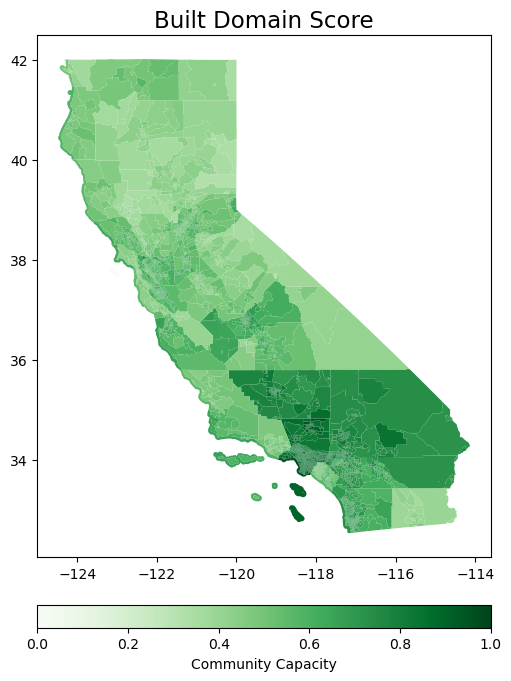

In [26]:
plot_domain_score(built_environment_domain_score,
                  column_to_plot='built_environment_domain_score',
                  domain=domain_prefix)

### We can also visualize specific areas!
We call from a the `plot_region_domain` function which has a number of variables:

df : DataFrame
        A DataFrame containing the data you want to plot, which must include the column 'GEOID' to match with the census tract data.
    
    counties_to_plot : list of str, optional
        A list of county FIPS codes (as strings) to plot. If None, no counties will be plotted.
        Example: ['037', '071', '065', '029', '111'].
    
    region : str, optional
        A predefined region to plot. Options: 'bay_area', 'central_region', 'inland_deserts', 'north_central', 'northern', or 'south_coast'.
        If specified, this will override `counties_to_plot`.
    
    plot_all : bool, optional
        If True, plots all counties in California. Overrides `counties_to_plot` and `region`.
    
    savefig : bool, optional
        If True, the plot will be saved as a PNG file. Default is False.
    
    font_color : str, optional
        Color of the font for county labels. Default is 'black'.
    
    domain : str, optional
        The domain name used for labeling and column names. Default is 'society_economy_'.
    
    domain_label_map : dict, optional
        A dictionary to map the domain variable to a more readable label. Example: {'society_economy_': 'Society and Economy Domain'}
    
    vmin : int, optional
        set the minimum bounds of the color gradient
        defualt is 0
    
    vmax : int, optional
        set the maximum bounds of the color gradient
        default is 3
    
    column_to_plot : str
        name of the column to be plotted
    
    cmap : str, optional
        name of the cmap to be used, 'Greens' is the default
    
    intro_title : str, optional
        first portion of the figure title, default is 'Domain Score'

    Dictionary of county labels
    county_labels = {
        '001': 'Alameda', '003': 'Alpine', '005': 'Amador', '007': 'Butte', '009': 'Calaveras',
        '011': 'Colusa', '013': 'Contra Costa', '015': 'Del Norte', '017': 'El Dorado', '019': 'Fresno',
        '021': 'Glenn', '023': 'Humboldt', '025': 'Imperial', '027': 'Inyo', '029': 'Kern',
        '031': 'Kings', '033': 'Lake', '035': 'Lassen', '037': 'Los Angeles', '039': 'Madera',
        '041': 'Marin', '043': 'Mariposa', '045': 'Mendocino', '047': 'Merced', '049': 'Modoc',
        '051': 'Mono', '053': 'Monterey', '055': 'Napa', '057': 'Nevada', '059': 'Orange',
        '061': 'Placer', '063': 'Plumas', '065': 'Riverside', '067': 'Sacramento', '069': 'San Benito',
        '071': 'San Bernardino', '073': 'San Diego', '075': 'San Francisco', '077': 'San Joaquin',
        '079': 'San Luis Obispo', '081': 'San Mateo', '083': 'Santa Barbara', '085': 'Santa Clara',
        '087': 'Santa Cruz', '089': 'Shasta', '091': 'Sierra', '093': 'Siskiyou', '095': 'Solano',
        '097': 'Sonoma', '099': 'Stanislaus', '101': 'Sutter', '103': 'Tehama', '105': 'Trinity',
        '107': 'Tulare', '109': 'Tuolumne', '111': 'Ventura', '113': 'Yolo', '115': 'Yuba'

You can plot a domains vulnerability index by region, specific county/counties, or the entirety of CA with labels
Below are a few example of each of these plotting scenarios

Number of invalid geometries: 0


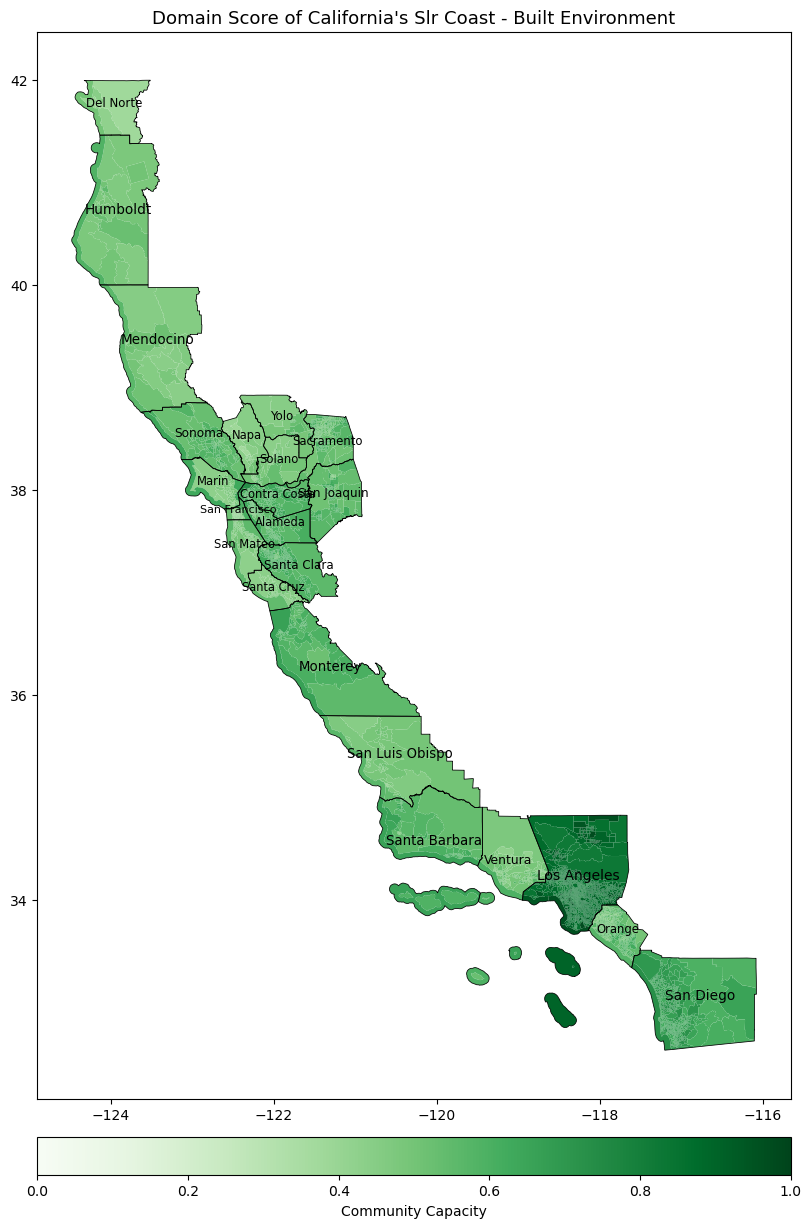

In [27]:
plot_region_domain(built_environment_domain_score,
                  column_to_plot='built_environment_domain_score',
                  domain=domain_prefix,
                  domain_label_map={domain_prefix: 'Built Environment'},
                  region='slr_coast',
                  savefig=False, 
                  font_color='black')

Number of invalid geometries: 0


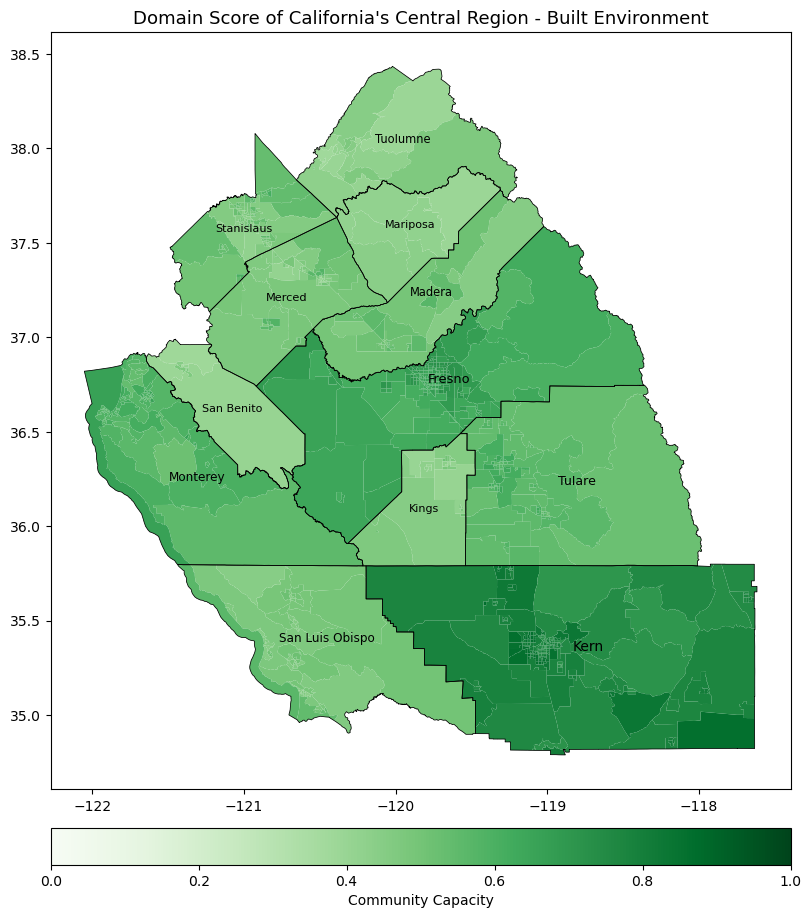

In [28]:
plot_region_domain(built_environment_domain_score,
                  column_to_plot='built_environment_domain_score',
                  domain=domain_prefix,
                  domain_label_map={domain_prefix: 'Built Environment'}, 
                  region='central_region', 
                  savefig=False, 
                  font_color='black')

Number of invalid geometries: 0


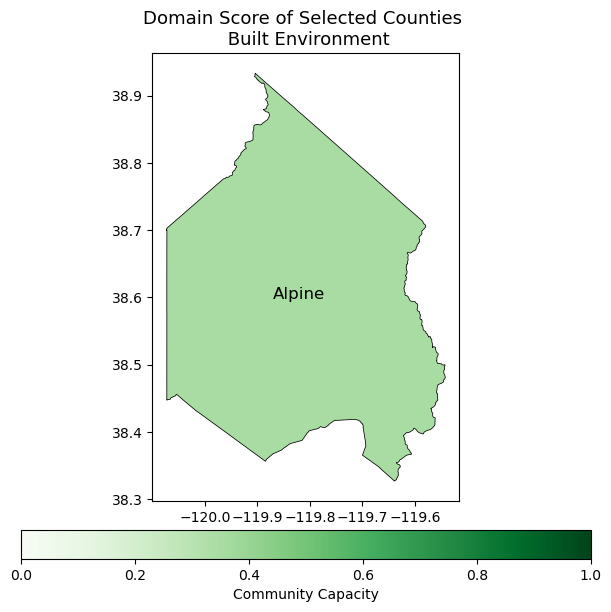

In [29]:
list_of_counties = ['003']
plot_region_domain(built_environment_domain_score,
                  column_to_plot='built_environment_domain_score',
                  domain=domain_prefix,
                  domain_label_map={domain_prefix: 'Built Environment'}, 
                  counties_to_plot=list_of_counties,
                  savefig=False,
                  font_color='black')

Number of invalid geometries: 0


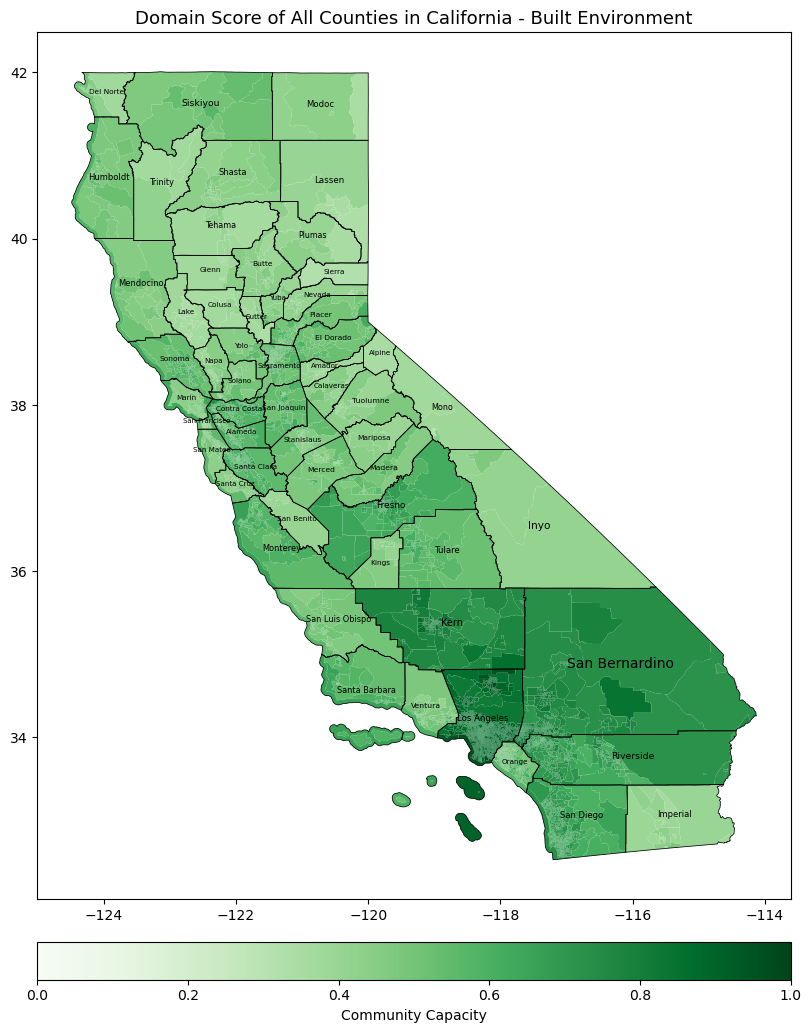

In [30]:
plot_region_domain(built_environment_domain_score,
                  column_to_plot='built_environment_domain_score',
                  domain=domain_prefix,
                  domain_label_map={domain_prefix: 'Built Environment'}, 
                  plot_all=True, 
                  savefig=False, 
                  font_color='black')

## Export the final domain csv file

In [31]:
# set-up file for export
domain_filename = '{}environment_domain_score.csv'.format(domain_prefix)
built_environment_domain_score.to_csv(domain_filename, index=False)

## Upload the indicator and domain score csv files to AWS

In [33]:
# upload to aws bucket
bucket_name = 'ca-climate-index'
directory = '3_fair_data/index_data'

files_upload = indicator_filename, domain_filename

for file in files_upload:
    upload_csv_aws([file], bucket_name, directory)

built_domain_averaged_indicators.csv uploaded to AWS
built_environment_domain_score.csv uploaded to AWS
